In [1]:
import numpy as np
import pandas as pd
import os

import re
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 data/69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 data/Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 data/Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 data/biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 data/bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 data/biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 data/cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 data/economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 data/internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 data/iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 data/kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  20M Jan 15 18:18 data/kultura.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 

In [3]:
name_dataset = '69-.paralel'

### load data

In [4]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(1427, 7)
CPU times: user 379 ms, sys: 14 ms, total: 393 ms
Wall time: 408 ms


In [5]:
df = df[df.text!='text']
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic
0,1999-12-24 12:00:00,https://lenta.ru/news/1999/12/24/nornikel/,NaN,Экономика,"""Норильский никель"" купил ""Мурманские авиалинии""","23 декабря авиакомпания ""Мурманские авиалинии""...",69-я параллель
1,1999-11-26 12:00:00,https://lenta.ru/news/1999/11/26/destroyers/,NaN,Экономика,В Питере построят миноносцы для Китая,"МДМ-Банк и судостроительный завод ""Северная ве...",69-я параллель


### preprocess

* get dates

In [6]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

CPU times: user 9.7 ms, sys: 0 ns, total: 9.7 ms
Wall time: 14.6 ms


<unknown>:2: DeprecationWarning: invalid escape sequence \d


* clean text

In [7]:
import preprocessing_tools as pr

In [8]:
%%time
df.text = df.text.apply(pr.clean_text)

CPU times: user 237 ms, sys: 0 ns, total: 237 ms
Wall time: 241 ms


In [9]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
0,1999-12-24 12:00:00,https://lenta.ru/news/1999/12/24/nornikel/,NaN,Экономика,"""Норильский никель"" купил ""Мурманские авиалинии""",декабря авиакомпания мурманские авиалинии была...,69-я параллель,"[(1999, 12, 24)]",1999,12
1,1999-11-26 12:00:00,https://lenta.ru/news/1999/11/26/destroyers/,NaN,Экономика,В Питере построят миноносцы для Китая,мдмбанк и судостроительный завод северная верф...,69-я параллель,"[(1999, 11, 26)]",1999,11


* cleanedNames

In [10]:
from cleanedNames import KeyProc
cn = KeyProc()

In [11]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

CPU times: user 3.24 s, sys: 0 ns, total: 3.24 s
Wall time: 3.29 s


* lemmatization

In [12]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

CPU times: user 10.4 s, sys: 318 µs, total: 10.4 s
Wall time: 10.5 s


* add docID

In [13]:
df['docID'] = list(range(df.shape[0]))

In [14]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,1999,12,"[декабрь, авиакомпания, мурманский, авиалиния,..."
1,1,1999,11,"[мдмбанк, судостроительный, завод, северный, в..."


In [15]:
print(df.shape)
df.isnull().sum()

(1427, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [16]:
df.year.min()

1999

## model

* prepare

In [17]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 21.6 ms, sys: 4.07 ms, total: 25.7 ms
Wall time: 25.2 ms


In [18]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [19]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

create folder...

artm.BatchVectorizer(data_path="data/batches/69-.paralel", num_batches=2)
CPU times: user 643 ms, sys: 8.89 ms, total: 651 ms
Wall time: 614 ms


In [20]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [21]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=6435f8b7-b594-4343-8b7f-449f2ae9a13f, num_entries=2483)

In [22]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [23]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

for i in range(2,20+1,1):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

    # regularizers
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)
    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)
    
newTime = time.now() #

#topic 2.........
	SparsityThetaScore: 0.12613874673843384
	SparsityPhiScore: 0.2057994306087494
	PerplexityScore: 1502.474365234375
	time: 0:00:08.668950
#topic 3.........
	SparsityThetaScore: 0.24830646812915802
	SparsityPhiScore: 0.34299907088279724
	PerplexityScore: 1381.018798828125
	time: 0:00:09.496540
#topic 4.........
	SparsityThetaScore: 0.38297125697135925
	SparsityPhiScore: 0.4228755533695221
	PerplexityScore: 1244.418701171875
	time: 0:00:11.098976
#topic 5.........
	SparsityThetaScore: 0.44120532274246216
	SparsityPhiScore: 0.4947241246700287
	PerplexityScore: 1178.8819580078125
	time: 0:00:11.481766
#topic 6.........
	SparsityThetaScore: 0.48738613724708557
	SparsityPhiScore: 0.552624523639679
	PerplexityScore: 1107.4415283203125
	time: 0:00:12.817443
#topic 7.........
	SparsityThetaScore: 0.5392932295799255
	SparsityPhiScore: 0.5851792097091675
	PerplexityScore: 1063.906005859375
	time: 0:00:11.809613
#topic 8.........
	SparsityThetaScore: 0.5828661322593689
	SparsityPh

In [31]:
#model_list

Text(0.5, 1.0, 'SparsityPhiScore')

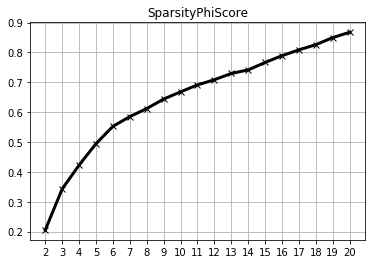

In [24]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [25]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

In [26]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

{0.2: 1, 0.3: 1, 0.4: 2, 0.5: 2, 0.6: 4, 0.7: 5, 0.8: 4}

Text(0.5, 1.0, 'SparsityThetaScore')

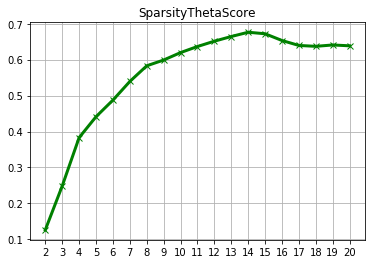

In [27]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [28]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

In [29]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

{0.1: 1, 0.2: 1, 0.3: 1, 0.4: 2, 0.5: 3, 0.6: 11}

Text(0.5, 1.0, 'PerplexityScore')

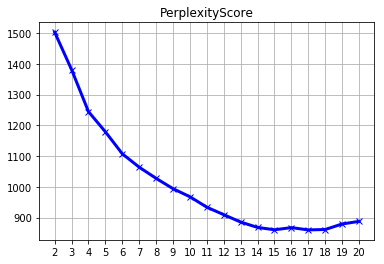

In [30]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [31]:
perplexity

[1502.474365234375,
 1381.018798828125,
 1244.418701171875,
 1178.8819580078125,
 1107.4415283203125,
 1063.906005859375,
 1027.6239013671875,
 994.080078125,
 967.8690795898438,
 933.9046630859375,
 909.658935546875,
 885.6006469726562,
 868.1777954101562,
 860.62841796875,
 867.5969848632812,
 860.1399536132812,
 861.4911499023438,
 879.455322265625,
 887.920654296875]

### select the best model

In [32]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

d_sphi:   {0.2: 1, 0.3: 1, 0.4: 2, 0.5: 2, 0.6: 4, 0.7: 5, 0.8: 4}
d_stheta: {0.1: 1, 0.2: 1, 0.3: 1, 0.4: 2, 0.5: 3, 0.6: 11}


In [39]:
select_topics = 17 # u should choose number of topic

best_model = model_list[select_topics-2]
print(best_model.num_topics)

17


### print top words for each topics

In [40]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['исследование' 'научный' 'институт' 'имя' 'университет' 'станция'
 'изучение' 'рана' 'среда' 'наука']
topic_1: ['красноярск' 'наш' 'универсиада' 'зимний' 'объединение' 'федерация'
 'соревнование' 'игра' 'спортсмен' 'эвенкийский']
topic_2: ['километр' 'памятник' 'установить' 'шельф' 'нефть' 'граница' 'война'
 'отечественный' 'великий' 'континентальный']
topic_3: ['таймырский' 'бюджет' 'таймыр' 'президент' 'появиться' 'вопрос'
 'ненецкий' 'средство' 'решение' 'писать']
topic_4: ['сентябрь' 'русский' 'аэропорт' 'реконструкция' 'порт' 'составлять'
 'крупный' 'стоимость' 'транспортный' 'пассажир']
topic_5: ['самолёт' 'доставить' 'школьник' 'норвежский' 'учебный' 'храм' 'вертолёт'
 'церковь' 'технопарк' 'посадка']
topic_6: ['дорога' 'жильё' 'дом' 'ремонт' 'ночь' 'договор' 'народный' 'солнце'
 'железный' 'жилой']
topic_7: ['ребёнок' 'конкурс' 'акция' 'семья' 'школа' 'детский' 'врач'
 'образование' 'больница' 'медицинский']
topic_8: ['посёлок' 'мероприятие' 'фестиваль' 'проводиться' 

### get topics-docs matrix

shape theta: (17, 1427)


/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/matplotlib/image.py:863: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  self.axes.set_xlim((xmin, xmax), auto=None)


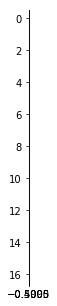

In [41]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(5, 5))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [42]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16
1000,0.000000,0.012449,0.000000,0.202855,0.000000,0.000000,0.282822,0.000000,0.014369,0.000000,0.0,0.0,0.000000,0.264311,0.170398,0.000000,0.052796
1001,0.059112,0.022331,0.000000,0.156246,0.008991,0.000000,0.000000,0.000000,0.000000,0.023783,0.0,0.0,0.000000,0.072638,0.344227,0.043751,0.268920
1002,0.350465,0.000000,0.000000,0.121229,0.000000,0.000000,0.000000,0.080359,0.000000,0.000000,0.0,0.0,0.000000,0.248112,0.000000,0.199835,0.000000
1003,0.000000,0.013209,0.000000,0.417964,0.128057,0.000000,0.021730,0.043809,0.000000,0.000000,0.0,0.0,0.044265,0.000000,0.330966,0.000000,0.000000
1004,0.000000,0.000000,0.066262,0.000000,0.000000,0.414012,0.000000,0.000000,0.007440,0.000000,0.0,0.0,0.070956,0.066006,0.375325,0.000000,0.000000


## DataViz

In [43]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16
0,0,1999,12,0.0,0.000000,0.000000,0.394207,0.296907,0.0,0.027085,0.000000,0.117416,0.000000,0.109450,0.000000,0.000000,0.0,0.054934,0.0,0.000000
1,1,1999,11,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.110583,0.000000,0.000000,0.081706,0.313031,0.000000,0.000000,0.0,0.213315,0.0,0.281365
2,2,1999,11,0.0,0.013189,0.000000,0.620798,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.133831,0.000000,0.067538,0.0,0.164644,0.0,0.000000
3,3,2000,1,0.0,0.036801,0.155815,0.062673,0.366805,0.0,0.065432,0.000000,0.000000,0.046026,0.000000,0.000000,0.000000,0.0,0.245129,0.0,0.021318
4,4,2000,5,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.130159,0.000000,0.000000,0.000000,0.053421,0.000000,0.0,0.725707,0.0,0.090713


In [44]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (182, 17)


topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  \
year month                                                               
1999 11     0.000000  0.013189  0.000000  0.620798  0.000000  0.000000   
     12     0.000000  0.000000  0.000000  0.394207  0.296907  0.000000   
2000 1      0.000000  0.036801  0.155815  0.062673  0.366805  0.000000   
     2      0.000000  0.000000  0.293292  0.401065  0.000000  0.000000   
     3      0.121986  0.157992  0.000000  0.449061  0.000000  0.034629   

             topic_6   topic_7   topic_8   topic_9  topic_10  topic_11  \
year month                                                               
1999 11     0.110583  0.000000  0.000000  0.081706  0.446862  0.000000   
     12     0.027085  0.000000  0.117416  0.000000  0.109450  0.000000   
2000 1      0.065432  0.000000  0.000000  0.046026  0.000000  0.000000   
     2      0.000000  0.186165  0.000000  0.000000  0.000000  0.000000   
     3      0.393574  0.091071  0.173722  0.231181  0.000000  0.018696   

            topic_12  topic_13  topic_14  topic_15  topic_16  
year month                                                    
1999 11     0.067538  0.000000  0.377958  0.000000  0.281365  
     12     0.000000  0.000000  0.054934  0.000000  0.000000  
2000 1      0.000000  0.000000  0.245129  0.000000  0.021318  
     2      0.000000  0.010257  0.109220  0.000000  0.000000  
     3      0.000000  0.000000  0.295746  0.032343  0.000000

### straightforward matrix heatmap

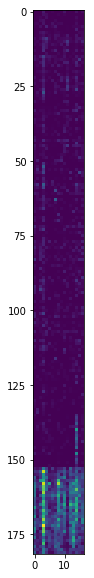

In [47]:
plt.figure(figsize=(10, 10))
plt.imshow(gb[topics])

## pygal

In [48]:
import pygal
from IPython.display import SVG, HTML

In [49]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [50]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [51]:
line_chart.render_to_file(f"data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg")

## joypy

In [52]:
import joypy # !pip install joypy

In [53]:
print(joined.shape)
joined.head()

(1427, 20)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16
0,0,1999,12,0.0,0.000000,0.000000,0.394207,0.296907,0.0,0.027085,0.000000,0.117416,0.000000,0.109450,0.000000,0.000000,0.0,0.054934,0.0,0.000000
1,1,1999,11,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.110583,0.000000,0.000000,0.081706,0.313031,0.000000,0.000000,0.0,0.213315,0.0,0.281365
2,2,1999,11,0.0,0.013189,0.000000,0.620798,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.133831,0.000000,0.067538,0.0,0.164644,0.0,0.000000
3,3,2000,1,0.0,0.036801,0.155815,0.062673,0.366805,0.0,0.065432,0.000000,0.000000,0.046026,0.000000,0.000000,0.000000,0.0,0.245129,0.0,0.021318
4,4,2000,5,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.130159,0.000000,0.000000,0.000000,0.053421,0.000000,0.0,0.725707,0.0,0.090713


In [54]:
joined['year_month'] = joined.apply(lambda x: str(int(x.year)) +'-'+ str(int(x.month)) + '-01', axis=1)
joined.reset_index(inplace=True)

joined.head()

,index,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,...,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,year_month
0,0,0,1999,12,0.0,0.000000,0.000000,0.394207,0.296907,0.0,...,0.117416,0.000000,0.109450,0.000000,0.000000,0.0,0.054934,0.0,0.000000,1999-12-01
1,1,1,1999,11,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.081706,0.313031,0.000000,0.000000,0.0,0.213315,0.0,0.281365,1999-11-01
2,2,2,1999,11,0.0,0.013189,0.000000,0.620798,0.000000,0.0,...,0.000000,0.000000,0.133831,0.000000,0.067538,0.0,0.164644,0.0,0.000000,1999-11-01
3,3,3,2000,1,0.0,0.036801,0.155815,0.062673,0.366805,0.0,...,0.000000,0.046026,0.000000,0.000000,0.000000,0.0,0.245129,0.0,0.021318,2000-1-01
4,4,4,2000,5,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.053421,0.000000,0.0,0.725707,0.0,0.090713,2000-5-01


In [55]:
joined_melt = joined.melt('year_month', var_name='topic', value_name='text')
print(joined_melt.shape)
joined_melt.head()

(29967, 3)


,year_month,topic,text
0,1999-12-01,index,0.0
1,1999-11-01,index,1.0
2,1999-11-01,index,2.0
3,2000-1-01,index,3.0
4,2000-5-01,index,4.0


In [56]:
# select only topic_*
joined_melt_new = joined_melt[(joined_melt.topic!='docID') & (joined_melt.topic!='index')
                              & (joined_melt.topic!='year') & (joined_melt.topic!='month')]
print(joined_melt_new.shape)
joined_melt_new.topic.value_counts()

(24259, 3)


topic_14    1427
topic_2     1427
topic_1     1427
topic_5     1427
topic_4     1427
topic_15    1427
topic_6     1427
topic_7     1427
topic_0     1427
topic_16    1427
topic_8     1427
topic_13    1427
topic_10    1427
topic_11    1427
topic_12    1427
topic_3     1427
topic_9     1427
Name: topic, dtype: int64

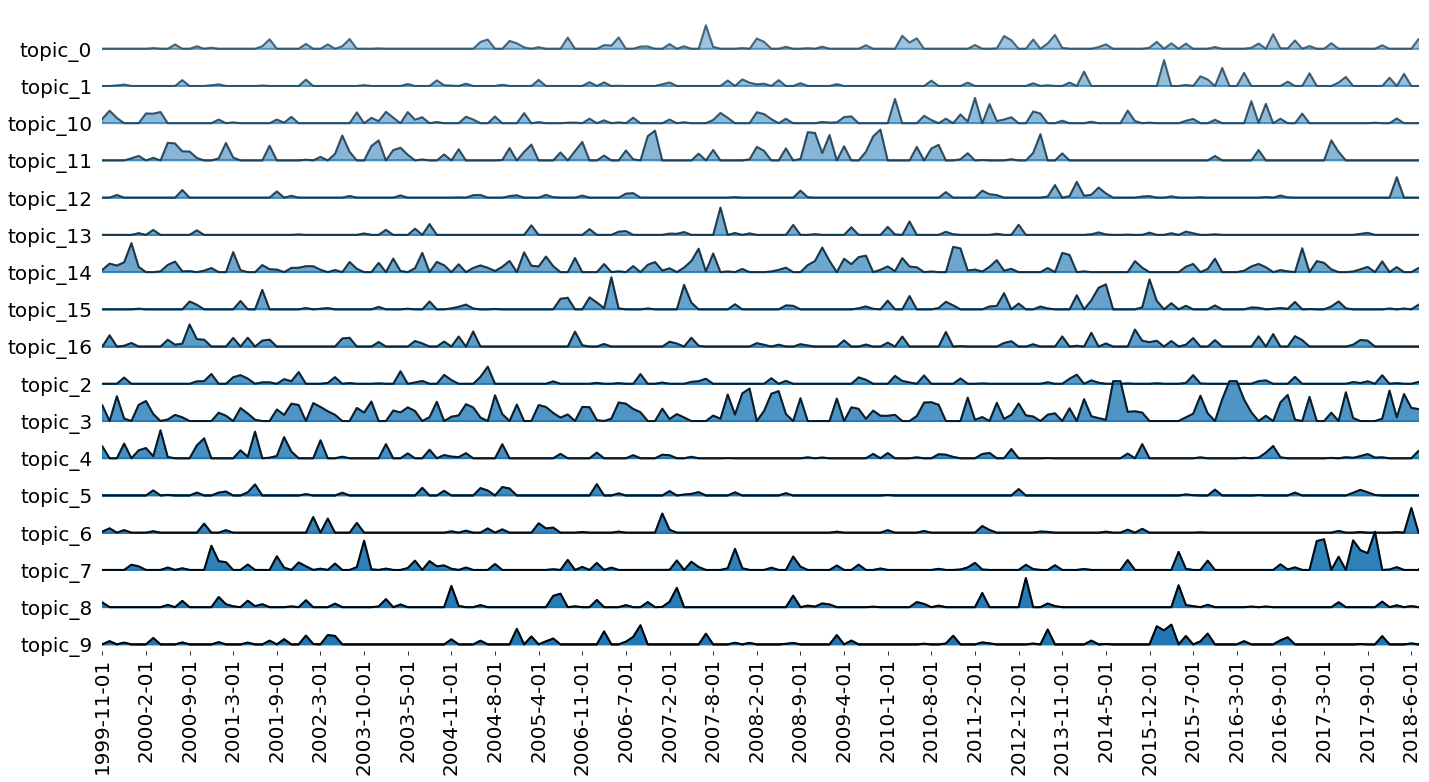

In [57]:
labels = sorted(joined_melt_new['year_month'].unique())

fig, axes = joypy.joyplot(joined_melt_new, by='topic', column='text', figsize=(20, 10),xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True, linecolor="k", linewidth=2,
                          kind='values', fade=True, xrot=90, x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [58]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")